In [ ]:
pip install pycbc

     |████████████████████████████████| 6.7 MB 6.3 MB/s 
     |████████████████████████████████| 7.3 MB 32.6 MB/s 
     |████████████████████████████████| 1.4 MB 41.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 46.3 MB 1.6 MB/s 
     |████████████████████████████████| 45 kB 3.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 201 kB 76.3 MB/s 
     |████████████████████████████████| 78 kB 6.3 MB/s 
     |████████████████████████████████| 51 kB 6.8 MB/s 
     |████████████████████████████████| 55 kB 4.2 MB/s 
     |████████████████████████████████| 295 kB 55.7 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... 

In [ ]:
from pycbc.catalog import Merger
#import pycbc
import scipy.constants as cnt
from scipy.stats import chisquare
import numpy as np
from numpy.ma.core import argmax
import pandas as pd
from google.colab import files
from math import pi
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.integrate import quad
from matplotlib.colors import BoundaryNorm
from scipy.interpolate import make_interp_spline

from matplotlib.ticker import MaxNLocator
import numpy.ma as ma
from scipy.optimize import curve_fit
import matplotlib.colors as mcolors
plt.rcParams.update({
    'figure.dpi': 200,
    'figure.figsize': (4, 3),
})
plt.rcParams.update({'font.size': 8})
cmap = plt.cm.get_cmap('Spectral')
M_sun = 1.989*10**30

print("All requirements setup")

All requirements setup


In [ ]:
'''
Generate Fake Noise and Inject a signal in it
'''
import pycbc.noise, pycbc.psd
import pylab,random,numpy
from pycbc.conversions import mass1_from_mchirp_q, mass2_from_mchirp_q
from pycbc.waveform import get_td_waveform, taper_timeseries
from pycbc.detector import Detector
from pycbc.types import FrequencySeries, TimeSeries
from pycbc.pnutils import nearest_larger_binary_number
from pycbc import DYN_RANGE_FAC
from pycbc.filter import sigma
import logging
from pycbc import frame
import warnings
warnings.filterwarnings("ignore")

colors = ["#2CBDEF", '#9D2EC5', '#EC1C4B', '#355C7D']

import seaborn as sns
sns.set_context('talk') 
sns.set_palette('colorblind')
sns.set_style('ticks')

pylab.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
        'text.usetex': False,
        'font.size':8,
        'legend.fontsize': 10,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8
    }
)

pylab.rcParams['axes.linewidth'] = 1

log_level = logging.INFO
logging.basicConfig(level=log_level,
                    format='%(asctime)s %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')

def make_padded_frequency_series(vec, filter_N=None, delta_f=None):
    logging.info("Generating frequency domain version of the waveform")
    if filter_N is None:
        power = ceil(log(len(vec), 2)) + 1
        N = 2 ** power
    else:
        N = filter_N
    n = N // 2 + 1

    if isinstance(vec, FrequencySeries):
        vectilde = FrequencySeries(zeros(n, dtype=complex_same_precision_as(vec)),
                                   delta_f=1.0, copy=False)
        if len(vectilde) < len(vec):
            cplen = len(vectilde)
        else:
            cplen = len(vec)
        vectilde[0:cplen] = vec[0:cplen]
        delta_f = vec.delta_f

    elif isinstance(vec, TimeSeries):
        curr_length = len(vec)
        new_length = int(nearest_larger_binary_number(curr_length))
        while new_length * vec.delta_t < 1./delta_f:
            new_length = new_length * 2
        vec.resize(new_length)

        v_tilde = vec.to_frequencyseries()
        i_delta_f = v_tilde.get_delta_f()
        v_tilde = v_tilde.numpy()
        df_ratio = int(delta_f / i_delta_f)
        n_freq_len = int((n-1) * df_ratio +1)
        assert(n <= len(v_tilde))
        df_ratio = int(delta_f / i_delta_f)
        v_tilde = v_tilde[:n_freq_len:df_ratio]
        vectilde = FrequencySeries(v_tilde, delta_f=delta_f, dtype=np.complex64)

    return FrequencySeries(vectilde * DYN_RANGE_FAC, delta_f=delta_f,
                           dtype=np.complex128)

def get_timeseries(mchirp_low, 
                   mchirq_high, 
                   min_mratio, 
                   max_mratio,
                   min_snr,
                   max_snr,
                   min_eccentricity,
                   max_eccentricity,
                   case,
                   get_image,
                   get_strain_zoom):
    
    logging.info("Generating Fake Strain")
    noise_l = 256
    flow = 10.0
    delta_f = 1.0 / noise_l
    flen = int(2048 / delta_f) + 1
    psd = pycbc.psd.aLIGOAPlusDesignSensitivityT1800042(flen, delta_f, flow)

    # Generate 64 seconds of noise at 4096 Hz
    seed = random.randint(10, 200)
    random.seed(seed)
    delta_t = 1.0 / 4096
    tsamples = int(noise_l / delta_t)
    ts = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=seed)
    if get_image:
        pylab.figure(figsize=(15,3))
        pylab.grid(zorder=1)
        pylab.plot(ts.sample_times, ts, color=colors[2],zorder=2)
        pylab.ylabel('Strain')
        pylab.xlabel('Time (s)')
        pylab.show()
    
    # Make life hell 
    mchirp = random.uniform(mchirp_low, 
                            mchirq_high)
    
    q = random.uniform(min_mratio, 
                       max_mratio)
    
    optimal_snr = random.randint(min_snr, 
                                 max_snr)
    
    eccentricity = random.uniform(min_eccentricity, 
                                  max_eccentricity)

    # NOTE: Inclination runs from 0 to pi, with poles at 0 and pi
    #       coa_phase runs from 0 to 2 pi.    
    inclination = random.uniform(0, numpy.pi)
    coa_phase = random.uniform(0, numpy.pi)

    
    declination  = random.uniform(0, numpy.pi)
    right_ascension = random.uniform(0, numpy.pi)
    polarization = random.uniform(0, numpy.pi)
    
    # Don't change the end_time otherwise the signal will be 
    # injected outside the region of generated noise
    end_time = random.randint(10,25)
    
    logging.info('Generating waveform')
    mass1 = mass1_from_mchirp_q(mchirp, q)
    mass2 = mass2_from_mchirp_q(mchirp, q)
    
    apx = 'EccentricTD'
    hp, hc = get_td_waveform(approximant=apx,
                             mass1=mass1,
                             mass2=mass1,
                             eccentricity = eccentricity,
                             inclination = inclination,
                             coa_phase = coa_phase,
                             delta_t = delta_t,
                             f_lower = 10)

    det_h1 = Detector('H1')
    signal_h1 = det_h1.project_wave(hp, hc,  right_ascension, declination, polarization)
    
    if get_image:
        pylab.figure(figsize=(15,3))
        pylab.grid(zorder=1)
        pylab.plot(signal_h1.sample_times, signal_h1, label='H1', color=colors[2],zorder=2)
        pylab.ylabel('Strain')
        pylab.xlabel('Time (s)')
        pylab.title(r'$case={},mchirp={:0.2f},~e={:1.2f},~\iota={:1.2f},~\varphi_c={:1.2f},~RA={:1.2f},~DEC={:1.2f},~SNR={:1.2f}$'.format(case,
                                                                                                                                                     mchirp,
                                                                                                                                                     eccentricity,
                                                                                                                                                     inclination,
                                                                                                                                                     coa_phase,
                                                                                                                                                     right_ascension,
                                                                                                                                                     declination,
                                                                                                                                                     optimal_snr))
        
        pylab.show()
        
    logging.info('Tapering TimeSeries and scaling its SNR')
    
    signal_h1 = taper_timeseries(signal_h1, 'TAPER_STARTEND')
    stilde = make_padded_frequency_series(vec=signal_h1,filter_N=flen, delta_f=psd.delta_f)
    inj = stilde
    inj /= sigma(stilde, psd=psd, low_frequency_cutoff=10.0)
    inj = inj * optimal_snr
    inj = inj.to_timeseries(delta_t= ts.delta_t)
    
    logging.info("Applying injections")
    
    dt = end_time - ts.start_time
    inj = inj.cyclic_time_shift(dt)
    inj.start_time += end_time
    strain = (inj + ts)
    
        
    logging.info(r'$case={},mchirp={:0.2f},~e={:1.2f},~\iota={:1.2f},~\varphi_c={:1.2f},~ra={:1.2f},~dec={:1.2f},~SNR={:1.2f}$'.format(case,
                                                                                                                                                      mchirp,
                                                                                                                                                      eccentricity,
                                                                                                                                                      inclination,
                                                                                                                                                      coa_phase,                                                                                                                                             right_ascension,
                                                                                                                                                      declination,
                                                                                                                                                      optimal_snr))

    
  

    tc = end_time+hp.get_duration()
    
    if get_strain_zoom == True:
        #returns a strain zoomed in on the merger
        strain = strain.whiten(4, 4)#,remove_corrupted=False)
        if tc+3<= noise_l:
            data_zoom= strain.time_slice(tc-42,tc+3)
        else:
            data_zoom= strain.time_slice(tc-42,tc)
        return data_zoom, mchirp , eccentricity, tc, optimal_snr
    
    else:
        return strain, mchirp , eccentricity, tc, optimal_snr 

In [ ]:
#Modified Q transform from pycbc to return q value
def qtransform(strain, delta_t=None, delta_f=None, logfsteps=None,
              frange=None, qrange=(4,64), mismatch=0.2, return_complex=False):
    """ Return the interpolated 2d qtransform of this data

    Parameters
    ----------
    delta_t : {self.delta_t, float}
        The time resolution to interpolate to
    delta_f : float, Optional
        The frequency resolution to interpolate to
    logfsteps : int
        Do a log interpolation (incompatible with delta_f option) and set
        the number of steps to take.
    frange : {(30, nyquist*0.8), tuple of ints}
        frequency range
    qrange : {(4, 64), tuple}
        q range
    mismatch : float
        Mismatch between frequency tiles
    return_complex: {False, bool}
        return the raw complex series instead of the normalized power.

    Returns
    -------
    times : numpy.ndarray
        The time that the qtransform is sampled.
    freqs : numpy.ndarray
        The frequencies that the qtransform is sampled.
    qplane : numpy.ndarray (2d)
        The two dimensional interpolated qtransform of this time series.
    """
    from pycbc.filter.qtransform import qtiling, qplane
    from scipy.interpolate import interp2d
    import numpy as _numpy
    
    if frange is None:
        frange = (30, int(strain.sample_rate / 2 * 8))

    q_base = qtiling(strain, qrange, frange, mismatch)
    max_key, times, freqs, q_plane = qplane(q_base, strain.to_frequencyseries(),
                                      return_complex=return_complex)
    if logfsteps and delta_f:
        raise ValueError("Provide only one (or none) of delta_f and logfsteps")

    # Interpolate if requested
    if delta_f or delta_t or logfsteps:
        if return_complex:
            interp_amp = interp2d(times, freqs, abs(q_plane))
            interp_phase = interp2d(times, freqs, _numpy.angle(q_plane))
        else:
            interp = interp2d(times, freqs, q_plane)

    if delta_t:
        times = _numpy.arange(float(strain.start_time),
                                float(strain.end_time), delta_t)
    if delta_f:
        freqs = _numpy.arange(int(frange[0]), int(frange[1]), delta_f)
    if logfsteps:
        freqs = _numpy.logspace(_numpy.log10(frange[0]),
                                _numpy.log10(frange[1]),
                                 logfsteps)

    if delta_f or delta_t or logfsteps:
        if return_complex:
            q_plane = _numpy.exp(1.0j * interp_phase(times, freqs))
            q_plane *= interp_amp(times, freqs)
        else:
            q_plane = interp(times, freqs)

    return max_key, times, freqs, q_plane

In [ ]:
def chirp_e(mchirp, e):
    """
    Calculates the Effective Chirp Mass from the chirp mass and eccenricity at 10 Hz
    """
    a1 = 0.06110974175360381
    a2 = -0.4193723077257345
    
    b1 = 0.00801015132110059
    b2 = -2.14807199936756e-5
    b3 = 1.12702400406416e-8
    b4 = -1.9753003183066e-12

    c1 = 0.024204222771565382
    c2 = -6.261945897154536e-6
    c3 = 1.1175104924576945e-8
    c4 = -3.681726165703978e-12
    
    a = a1*mchirp + a2
    b = b1*mchirp**2 + b2*mchirp**4 + b3*mchirp**6 + b4*mchirp**8
    c = c1*mchirp**2 + c2*mchirp**4 + c3*mchirp**6 + c4*mchirp**8

    m_e = mchirp*(1 + a*e**2 + b*e**4 + c*e**6)
    
    return m_e

def gen_freq(m,e, times,tc):
    """
    Generate f(t) for given chirp mass (m) and eccentricity (e) and array of time (times) from effective
    """
    Me = chirp_e(m,e)
    return ((96*pi**(8/3)/5)*(cnt.G*Me*M_sun/cnt.c**3)**(5/3)*(tc-times)*8/3)**(-3/8)
    

In [ ]:
# m1 = [-0.37493451554842944, -0.374895145659326, -0.3748470856694093, -0.3747903876501027, -0.37472532510337725, -0.3746515601330759, -0.37456995124165365]
# m2 = [-0.37579992060794937, -0.37576454172266743, -0.37572016386964896, -0.3756674346931299, -0.37560649439005334, -0.37553677113812256, -0.3754580202719282]
# m3 = [-0.3784090768504471, -0.37838574476410625, -0.37835351041143456, -0.3783128348191226, -0.3782634642415448, -0.37820486462732733, -0.3781383162197524]
# m4 = [-0.3828011451737927, -0.38279808894210987, -0.38278741999213123, -0.3827674298811955, -0.38273935266614306, -0.38270156491773016, -0.38265507000835886]
# m5 = [-0.38904241463157757, -0.38907276839193966, -0.3890927028252096, -0.389104982580889, -0.38910845689552276, -0.38910272278628905, -0.38908871011121476]
# m6 = [-0.3972361991561368, -0.3973112422489705, -0.3973788587758861, -0.3974367999419669, -0.3974847343026427, -0.3975256978353127, -0.3975556224809436]
# i1 = [4.330736422745263, 4.234230913092853, 4.1505890924562445, 4.076769151493914, 4.010695346858928, 3.95088534048411, 3.8962489392913953]
# i2 = [4.332634490430967, 4.235924096486731, 4.152104149978091, 4.078128644333117, 4.011916634096749, 3.951981542200667, 3.8972269691177543]
# i3 = [4.338260609053682, 4.240932074975609, 4.156578962946542, 4.082134112432678, 4.015501449367462, 3.9551849377722132, 3.9000864006821834]
# i4 = [4.3474036923906585, 4.249033094615442, 4.163785453715923, 4.088550394981683, 4.021214582662267, 3.9602615027138315, 3.9045799237687437]
# i5 = [4.359687991007311, 4.259852717117349, 4.173329282367045, 4.096977975621278, 4.0286429919608615, 3.9667891172644123, 3.9102873954994113]
# i6 = [4.374570979342086, 4.272809510110389, 4.1846341361487545, 4.106821526228603, 4.037177134389722, 3.9741474927857805, 3.916563981228446]

m1 = [-0.37493451554842944, -0.3748470856694093, -0.37472532510337725, -0.37456995124165365, -0.374380297281468, -0.3741585472567045, -0.3739032963339358, -0.3736176328441664, -0.37329923204628424, -0.3729509896964767, -0.37257202128978006, -0.37216155923745986, -0.37172171672835747, -0.3712553618428428, -0.3707614912600221, -0.37023631760149683, -0.3696868910918175, -0.36910724614057505]
m2 = [-0.37579992060794937, -0.37572016386964896, -0.37560649439005334, -0.3754580202719282, -0.3752763423383297, -0.37506204142816907, -0.3748146182109281, -0.37453466438007377, -0.37422358320809457, -0.3738812562296657, -0.37350845172553765, -0.3731047696404811, -0.3726722995016769, -0.3722092619803968, -0.3717209232934698, -0.37120461404788785, -0.3706548906759195, -0.3700815237889728]
m3 = [-0.3784090768504471, -0.37835351041143456, -0.3782634642415448, -0.3781383162197524, -0.37798024948709813, -0.37778779963603903, -0.37756153705610646, -0.3773019430804813, -0.3770133879347689, -0.37669055434822163, -0.37633779594693745, -0.375951228711317, -0.37553836293374626, -0.37509182504816824, -0.374618894615957, -0.3741181677362094, -0.3735933891745284, -0.37303460686252754]
m4 = [-0.3828011451737927, -0.38278741999213123, -0.38273935266614306, -0.38265507000835886, -0.38253656690911275, -0.38238404492784256, -0.3821959900463923, -0.3819742452591173, -0.38172200841335296, -0.3814335381007202, -0.3811136111296967, -0.38076212003605525, -0.38038110327276237, -0.3799705972645602, -0.3795263098814531, -0.37905367291311653, -0.3785482151633377, -0.37802525121845765]
m5 = [-0.38904241463157757, -0.3890927028252096, -0.38910845689552276, -0.38908871011121476, -0.3890311276355326, -0.38893805152997635, -0.3888066174354655, -0.38864344899301323, -0.38844542486432193, -0.3882122715313949, -0.3879408484029777, -0.38764178675370603, -0.38731076975491585, -0.3869458497754027, -0.3865434983399411, -0.38612219441460605, -0.38565892397936835, -0.3851718396766384]
m6 = [-0.3972361991561368, -0.3973788587758861, -0.3974847343026427, -0.3975556224809436, -0.39758550793573216, -0.3975772815737538, -0.3975305906961954, -0.39744935211023047, -0.3973299508180536, -0.3971668045892392, -0.3969735866170437, -0.39675174833537896, -0.3964814414889759, -0.3961868018841008, -0.3958579964675702, -0.39548549331682914, -0.3951000858648261, -0.39466813968689546]
m7 = [-0.40752241255331584, -0.40779383139329434, -0.40802986314621864, -0.4082261696669817, -0.40837839727639136, -0.40848983422797375, -0.40856265371482564, -0.40858768886041813, -0.4085749688974897, -0.4085267272984538, -0.4084372592182331, -0.4083117740341783, -0.40814615644776114, -0.40794021974026873, -0.40769238716759354, -0.4074200318077169, -0.4071152460247754, -0.4067622222321571]
m8 = [-0.42009775676975575, -0.42055320423800097, -0.4209643666423168, -0.4213343694910117, -0.42165685839066636, -0.4219321011177664, -0.42216390838624435, -0.4223478631547682, -0.4224897385966314, -0.4225956823665824, -0.4226382529205904, -0.4226435768560631, -0.4226219766358603, -0.4225560762150117, -0.42242068464803995, -0.4222675544174728, -0.42208522947911065, -0.42185689981457625]
m9 = [-0.4352296112172272, -0.43593561527696767, -0.4365943933666997, -0.43721314766214026, -0.43776839412147484, -0.43827629608862617, -0.4387371469642579, -0.4391331281680453, -0.4394885155131872, -0.43978023566110136, -0.44002798920569536, -0.44024468529829996, -0.4403810368587487, -0.4404823535937237, -0.44056250946218695, -0.4405631831983547, -0.4405325327252258, -0.44045985939769594]

i1 = [4.330736422745263, 4.1505890924562445, 4.010695346858928, 3.8962489392913953, 3.7993509781075097, 3.7152972603770573, 3.641045515082877, 3.574531489437475, 3.5142705626061095, 3.4591794211235856, 3.4084278136533213, 3.361371079545925, 3.3175041714078795, 3.276421902600761, 3.2377860479300384, 3.2013117409719025, 3.166778765697369, 3.1339800907647843]
i2 = [4.332634490430967, 4.152104149978091, 4.011916634096749, 3.8972269691177543, 3.8001273703439766, 3.7158975950126387, 3.64149158489058, 3.5748338606831838, 3.514446819567713, 3.4592369985867206, 3.4083765071949763, 3.3612199548416757, 3.3172609609846, 3.2760843774838633, 3.2373637799101167, 3.200814922570796, 3.1661960072993645, 3.1333260862971146]
i3 = [4.338260609053682, 4.156578962946542, 4.015501449367462, 3.9000864006821834, 3.8023757295963967, 3.717611829227496, 3.64273285862569, 3.575649426817971, 3.5148820111485644, 3.459317064330178, 3.408130043132901, 3.3606641366619336, 3.3164211315541317, 3.2749718937330785, 3.2359921295314193, 3.199198387643269, 3.16436168085665, 3.131267849839112]
i4 = [4.3474036923906585, 4.163785453715923, 4.021214582662267, 3.9045799237687437, 3.8058358027916217, 3.7201782012445666, 3.6445056499995414, 3.5767104044099076, 3.5152937273346287, 3.4591298415781084, 3.407386775755789, 3.3594086999871724, 3.3146803014883544, 3.272782721588432, 3.233366544493028, 3.196158330415503, 3.1609138910126897, 3.1274561535181618]
i5 = [4.359687991007311, 4.173329282367045, 4.0286429919608615, 3.9102873954994113, 3.810078879362264, 3.7231480497461904, 3.6463433027033156, 3.5775377907690302, 3.515193700074221, 3.4581824411081854, 3.4056420474851548, 3.3569301193085197, 3.311510041941518, 3.268953877283519, 3.2289096158117943, 3.1911206343529446, 3.1553095002237477, 3.121301160437408]
i6 = [4.374570979342086, 4.1846341361487545, 4.037177134389722, 3.916563981228446, 3.8144376302422285, 3.7258357397503468, 3.647553026039008, 3.5774132782559502, 3.513848876357948, 3.4556995953870406, 3.402123410161815, 3.3524436080326008, 3.3060865872970404, 3.2626648232504327, 3.221806730743805, 3.183206151027314, 3.146664227298438, 3.111925246014041]
i7 = [4.391265877427178, 4.19686332218728, 4.045959810359968, 3.922517870980839, 3.817988007631845, 3.727290450718234, 3.6471504937790606, 3.575308854464245, 3.5101965835643028, 3.4506414533847565, 3.395739284407202, 3.3448077790105453, 3.2972907787738577, 3.252747268348611, 3.2108149514161646, 3.171220686368475, 3.133701350391228, 3.0980256238979766]
i8 = [4.4087155515085525, 4.208913732964061, 4.0538020930478735, 3.926913846575482, 3.8194505493380015, 3.726181604290682, 3.6437462124779287, 3.5698351552126195, 3.502824353937822, 3.441517089123479, 3.384946549354439, 3.332452252077948, 3.283485541118437, 3.2375633569254156, 3.1942833132940875, 3.1534117823753625, 3.1146734547969945, 3.077831031712989]
i9 = [4.425474712888087, 4.219215870673017, 4.059086130783738, 3.9280847832422534, 3.817079091991552, 3.720714736727684, 3.635511492200301, 3.559060683907698, 3.489725944651476, 3.426218489595159, 3.367632148064782, 3.313252116195138, 3.2624245955810465, 3.214752022884429, 3.1698666231350607, 3.127381701146869, 3.087092412595447, 3.0487627284166083]

ml = []
ml.append(m1)
ml.append(m2)
ml.append(m3)
ml.append(m4)
ml.append(m5)
ml.append(m6)
ml.append(m7)
ml.append(m8)
ml.append(m9)
sl = []
sl.append(i1)
sl.append(i2)
sl.append(i3)
sl.append(i4)
sl.append(i5)
sl.append(i6)
sl.append(i7)
sl.append(i8)
sl.append(i9)
# print(m)
print(sl[1][1])
print(ml[0][1])

4.152104149978091
-0.3748470856694093


In [ ]:
def freq_gen(slope, i, times, tc):
  """
  Generate f(t) for given chirp mass (m) and eccentricity (e) and array of time (times) from effective
  """
  return (np.exp(slope*np.log(tc-times)+i))

In [ ]:
def constant(m):
    const = -(3/8)*np.log((256*((np.pi)**(8/3))/5)*((cnt.G*m*M_sun/(cnt.c**3))**(5/3)))
    return const

def freq_gen2(slope, m, times, tc):
  """
  Generate f(t) for given chirp mass (m) and eccentricity (e) and array of time (times) from effective
  """
  return (np.exp(slope*np.log(tc-times)+ constant(m)))

In [ ]:
std_mine = [[8.285370758741653074e-02, 9.396314314123539735e-02, 9.984711564274389994e-02, 1.064806350894517833e-01, 1.272609366585214508e-01, 1.592594173169360749e-01, 2.367155787172311732e-01, 3.042554284421158939e-01, 3.349674222490543474e-01],
[8.250794476314476933e-02, 6.793190917052803479e-02, 7.809507873426582703e-02, 8.853776237091151580e-02, 1.227779192347493165e-01, 1.392395248554185172e-01, 1.980140486252083831e-01, 2.570949349963222441e-01, 3.797470761130888328e-01],
[5.953593960403366636e-02, 6.372591692235135552e-02, 6.947318901664327473e-02, 8.334393054945223034e-02, 9.786724482985943718e-02, 1.307430373717620720e-01, 1.591920444785937250e-01, 2.340449629655613484e-01, 2.896114963163453626e-01],
[5.424818423477384410e-02, 5.006086989670564813e-02, 5.452671017597442160e-02, 6.883369042824755146e-02, 9.564030546916756081e-02, 1.101846336268011289e-01, 1.294392969471709343e-01, 1.748376397481208044e-01, 2.685295925018212904e-01],
[4.693374024950948409e-02, 4.335863873725195189e-02, 4.692530216892067119e-02, 5.910307168089132257e-02, 6.716779660381622108e-02, 8.287735209068419762e-02, 1.188503946221782653e-01, 1.520170999269821743e-01, 1.852209688822420985e-01],
[3.851982787089742316e-02, 4.320433918556290664e-02, 5.225216398474698265e-02, 5.571197192793057168e-02, 8.162945419932207680e-02, 8.806269209699309208e-02, 9.651323877375589388e-02, 1.338124520406109574e-01, 1.708455512578302971e-01],
[4.120309459733314389e-02, 4.212230422285764136e-02, 4.962520827851375077e-02, 4.891624899833690171e-02, 8.380569971974285992e-02, 6.727650293434694895e-02, 8.448078038124211264e-02, 1.232427056346616090e-01, 2.171486900419469512e-01],
[4.892086304708626043e-02, 3.944940482875537724e-02, 5.133848234543379047e-02, 4.542437101470898908e-02, 5.687813028240891466e-02, 6.289874323216786134e-02, 7.372185497439776025e-02, 1.352473859482512530e-01, 2.079428765900895315e-01],
[4.017332543025990688e-02, 3.826340827884990026e-02, 4.769819818053618043e-02, 4.438225530661674134e-02, 5.139062049151604111e-02, 6.855922527634490671e-02, 1.061029278395729664e-01, 1.403162002270476882e-01, 2.317505744009575597e-01],
[4.242427271010202477e-02, 3.642065460592868592e-02, 4.018022511316252793e-02, 5.444194421831066721e-02, 4.287638058169049998e-02, 7.402160070397884040e-02, 9.071710605495920954e-02, 1.890489753050017818e-01, 2.853396963715924550e-01],
[4.096011499077525930e-02, 4.343028268853088569e-02, 4.315374688160619754e-02, 3.686862543295952449e-02, 5.370321385867757313e-02, 7.775076397783632631e-02, 1.105728770137632960e-01, 1.838536453219284106e-01, 3.348679095070620226e-01],
[4.069200414791756398e-02, 4.444460041105867398e-02, 3.795165306479890421e-02, 4.699207712299405953e-02, 5.830124697008670642e-02, 8.894602021631475841e-02, 1.087393335889038498e-01, 2.108398257723990421e-01, 3.423907899796650445e-01],
[4.586290317959708374e-02, 4.555136947084004878e-02, 5.057304437418130849e-02, 4.127660230230650179e-02, 5.334951964788110096e-02, 9.255142920542061558e-02, 2.401346381396975982e-01, 2.778039604911919924e-01, 5.772376805907130093e-01],
[4.266045348214785732e-02, 4.272192994332914273e-02, 4.194366170087018147e-02, 4.891724547283052282e-02, 7.693844582994521786e-02, 1.228597709724308512e-01, 1.109347129579615621e-01, 3.067951265730025634e-01, 2.960333325047421194e-01],
[4.731398541067236702e-02, 4.509720764634870399e-02, 5.669100815079918670e-02, 5.172660015546410445e-02, 8.113926293656380240e-02, 1.252448228640783423e-01, 2.591283522411538254e-01, 4.111849057224183368e-01, 3.600282273448963677e-01],
[4.558632387485923865e-02, 4.749931226850756527e-02, 5.659755187506325391e-02, 6.566835430856848843e-02, 9.983720877418163220e-02, 1.662062720277409089e-01, 2.018414852987486519e-01, 3.705673323082182002e-01, 3.492302567607629693e-01],
[4.988916588685551878e-02, 4.927708146046616555e-02, 5.958265504769563042e-02, 6.390082729155853458e-02, 1.089489920570673037e-01, 1.828604496012511682e-01, 1.999619445264229356e-01, 3.471635584375574735e-01, 2.320880869405585190e-01],
[5.464970247628531813e-02, 5.629888625788031370e-02, 6.877334411829996719e-02, 5.967797607136515747e-02, 1.061167173612396208e-01, 2.365588737072597536e-01, 3.161759095227865135e-01, 2.436522067132860514e-01, 4.159957466429730633e-01]]

std_mine2 = np.array(std_mine)
print(std_mine2.shape)

(18, 9)


In [ ]:
std_nirban = [[8.465633426017918350e-02, 8.715474519688766464e-02, 6.741701633591394571e-02, 4.985853822132498003e-02, 9.000915397231749882e-02, 2.447579848652624845e-01, 6.474115355936718164e-01, 1.557956461822236349e+00, 3.364785127752135896e+00],
[8.354294954655441807e-02, 6.014269232986981656e-02, 4.769253223530033059e-02, 4.265602176909612936e-02, 7.961802825528625782e-02, 2.241927101477611817e-01, 5.979900412895489126e-01, 1.371501026505667742e+00, 2.637143690372977911e+00],
[6.075333398683769454e-02, 5.634907400388607795e-02, 4.222038646874966272e-02, 4.257865110016997856e-02, 7.912547553652006516e-02, 2.227464889931209946e-01, 5.848240195300764555e-01, 1.192086780055603867e+00, 2.203074069792623213e+00],
[5.605416207636913783e-02, 4.509244355180836578e-02, 3.465198330571590130e-02, 4.279565682806975996e-02, 8.909972702331261929e-02, 2.045770444190920800e-01, 5.577502394319538981e-01, 1.163158853875416510e+00, 1.944245836443629027e+00],
[5.023028784098346189e-02, 4.104368562877930976e-02, 3.466397130886099409e-02, 4.295238214005715066e-02, 9.357169012722763024e-02, 2.354435886216137142e-01, 4.917586268579329789e-01, 8.616052519503070162e-01, 1.210578553621132425e+00],
[4.312949518696478080e-02, 4.375390043860290928e-02, 4.086504537718736729e-02, 4.687126832987238700e-02, 9.067403247910901798e-02, 2.040672561563459386e-01, 4.679660048700445274e-01, 7.344737258124331980e-01, 1.019641157927464459e+00],
[4.886999632858427672e-02, 4.467553062473386682e-02, 4.573394297611609038e-02, 4.925730634799830449e-02, 1.400211678135609983e-01, 2.295463013906034744e-01, 4.407881843244508269e-01, 5.308453178809013906e-01, 6.591473555882934043e-01],
[6.035666116857463931e-02, 4.583346317967524480e-02, 4.690558601561633373e-02, 5.373033027837660625e-02, 9.084303853927691574e-02, 2.004635477589534476e-01, 4.162033736298521025e-01, 4.698314490229934526e-01, 3.856804541264586828e-01],
[5.326162974714177684e-02, 4.791617572105552614e-02, 5.288910424801621102e-02, 6.169231956284580015e-02, 9.582298161823261939e-02, 1.874093587747529543e-01, 2.204265551565161574e-01, 2.883204489468040865e-01, 2.709222640050880648e-01],
[6.103569139736775284e-02, 5.044539689937665300e-02, 5.145938638605435794e-02, 6.587529169820403874e-02, 1.073073111513438010e-01, 1.740697129922075537e-01, 2.506765324620393032e-01, 2.037215361516480916e-01, 1.302626156311414984e-01],
[6.195084274266011992e-02, 6.389244097310102510e-02, 5.958539249898398005e-02, 6.512568419510043893e-02, 1.126670812279975120e-01, 1.864663311532103740e-01, 1.538578333430589973e-01, 1.905009974925221117e-01, 1.060897263863535578e+01],
[6.638634388615489990e-02, 6.909966132455193366e-02, 5.917142179434700666e-02, 7.442834953746040039e-02, 1.162178391386062548e-01, 1.681174953372295278e-01, 2.619124048097386526e-01, 1.076504162162146422e-01, 4.829207403928799103e+00],
[8.052994184185795212e-02, 7.908958252597844685e-02, 7.957539701085639128e-02, 7.765593423475621038e-02, 1.146709844652352567e-01, 1.569412671525184932e-01, 4.464753206357865434e-01, 1.610087799255529584e+00, 2.216754694564176376e+01],
[8.084082879917170450e-02, 7.583993707227716652e-02, 7.360185479015747545e-02, 8.957441532478824242e-02, 1.335949301756070851e-01, 2.015520392802747363e-01, 3.105707608437031642e-01, 3.847961581239362161e+00, 6.991342134301653743e+00],
[9.529563521398207171e-02, 8.450126384656919676e-02, 9.822455779120040087e-02, 9.380596803210619616e-02, 1.366300727103278156e-01, 1.990291568896581653e-01, 5.170075384524199791e-01, 5.270304023711515740e+00, 4.996532832940592073e+01],
[9.617115382075834551e-02, 9.647151230992097315e-02, 1.044983422483888313e-01, 1.146069002723796720e-01, 1.540819623131119975e-01, 2.455780836682085466e-01, 7.925983210226558162e-01, 3.756843465981689167e+00, 8.517892603898346238e+01],
[1.085104751770153420e-01, 1.019374748586128754e-01, 1.137010460934624323e-01, 1.139094791902301729e-01, 1.513674369944827958e-01, 3.029184429246595256e-01, 5.731428477773056196e-01, 7.446506054637195504e+00, 3.355857320908283725e+01],
[1.262320784378910821e-01, 1.186086105981347533e-01, 1.306346777022109329e-01, 1.112946963346652801e-01, 1.633161701924856768e-01, 3.655282630950094092e-01, 1.625202382724532768e+00, 4.699426175513607973e+00, 3.077649570562572379e+01]]
std_nirban2 = np.array(std_nirban)
print(std_nirban2.shape)

(18, 9)


In [ ]:
ms = np.linspace(3,21,19)
es = np.linspace(0,0.45,10)

In [ ]:
std_nirban2[10][8] = 0
std_nirban2[11][8] = 0
std_nirban2[12][7] = 0
std_nirban2[12][8] = 0
std_nirban2[13][7] = 0
std_nirban2[13][8] = 0
std_nirban2[14][7] = 0
std_nirban2[14][8] = 0
std_nirban2[15][7] = 0
std_nirban2[15][8] = 0
std_nirban2[16][7] = 0
std_nirban2[16][8] = 0
std_nirban2[17][6] = 0
std_nirban2[17][7] = 0
std_nirban2[17][8] = 0
print(std_nirban2)

[[0.08465633 0.08715475 0.06741702 0.04985854 0.09000915 0.24475798
  0.64741154 1.55795646 3.36478513]
 [0.08354295 0.06014269 0.04769253 0.04265602 0.07961803 0.22419271
  0.59799004 1.37150103 2.63714369]
 [0.06075333 0.05634907 0.04222039 0.04257865 0.07912548 0.22274649
  0.58482402 1.19208678 2.20307407]
 [0.05605416 0.04509244 0.03465198 0.04279566 0.08909973 0.20457704
  0.55775024 1.16315885 1.94424584]
 [0.05023029 0.04104369 0.03466397 0.04295238 0.09357169 0.23544359
  0.49175863 0.86160525 1.21057855]
 [0.0431295  0.0437539  0.04086505 0.04687127 0.09067403 0.20406726
  0.467966   0.73447373 1.01964116]
 [0.04887    0.04467553 0.04573394 0.04925731 0.14002117 0.2295463
  0.44078818 0.53084532 0.65914736]
 [0.06035666 0.04583346 0.04690559 0.05373033 0.09084304 0.20046355
  0.41620337 0.46983145 0.38568045]
 [0.05326163 0.04791618 0.0528891  0.06169232 0.09582298 0.18740936
  0.22042656 0.28832045 0.27092226]
 [0.06103569 0.0504454  0.05145939 0.06587529 0.10730731 0.174069

In [ ]:
std_mine2[10][8] = 0
std_mine2[11][8] = 0
std_mine2[12][7] = 0
std_mine2[12][8] = 0
std_mine2[13][7] = 0
std_mine2[13][8] = 0
std_mine2[14][7] = 0
std_mine2[14][8] = 0
std_mine2[15][7] = 0
std_mine2[15][8] = 0
std_mine2[16][7] = 0
std_mine2[16][8] = 0
std_mine2[17][6] = 0
std_mine2[17][7] = 0
std_mine2[17][8] = 0
print(std_mine2)

[[0.08285371 0.09396314 0.09984712 0.10648064 0.12726094 0.15925942
  0.23671558 0.30425543 0.33496742]
 [0.08250794 0.06793191 0.07809508 0.08853776 0.12277792 0.13923952
  0.19801405 0.25709493 0.37974708]
 [0.05953594 0.06372592 0.06947319 0.08334393 0.09786724 0.13074304
  0.15919204 0.23404496 0.2896115 ]
 [0.05424818 0.05006087 0.05452671 0.06883369 0.09564031 0.11018463
  0.1294393  0.17483764 0.26852959]
 [0.04693374 0.04335864 0.0469253  0.05910307 0.0671678  0.08287735
  0.11885039 0.1520171  0.18522097]
 [0.03851983 0.04320434 0.05225216 0.05571197 0.08162945 0.08806269
  0.09651324 0.13381245 0.17084555]
 [0.04120309 0.0421223  0.04962521 0.04891625 0.0838057  0.0672765
  0.08448078 0.12324271 0.21714869]
 [0.04892086 0.0394494  0.05133848 0.04542437 0.05687813 0.06289874
  0.07372185 0.13524739 0.20794288]
 [0.04017333 0.03826341 0.0476982  0.04438226 0.05139062 0.06855923
  0.10610293 0.1403162  0.23175057]
 [0.04242427 0.03642065 0.04018023 0.05444194 0.04287638 0.074021

In [ ]:
# std_nirban2[16, 0] = 0
# print(std_nirban2.T)
# std_nirban3 = np.zeros((std_nirban2.shape[0], std_nirban2.shape[1]))
# std_nirban3[0, 0] = 100 

0.37974707611308883


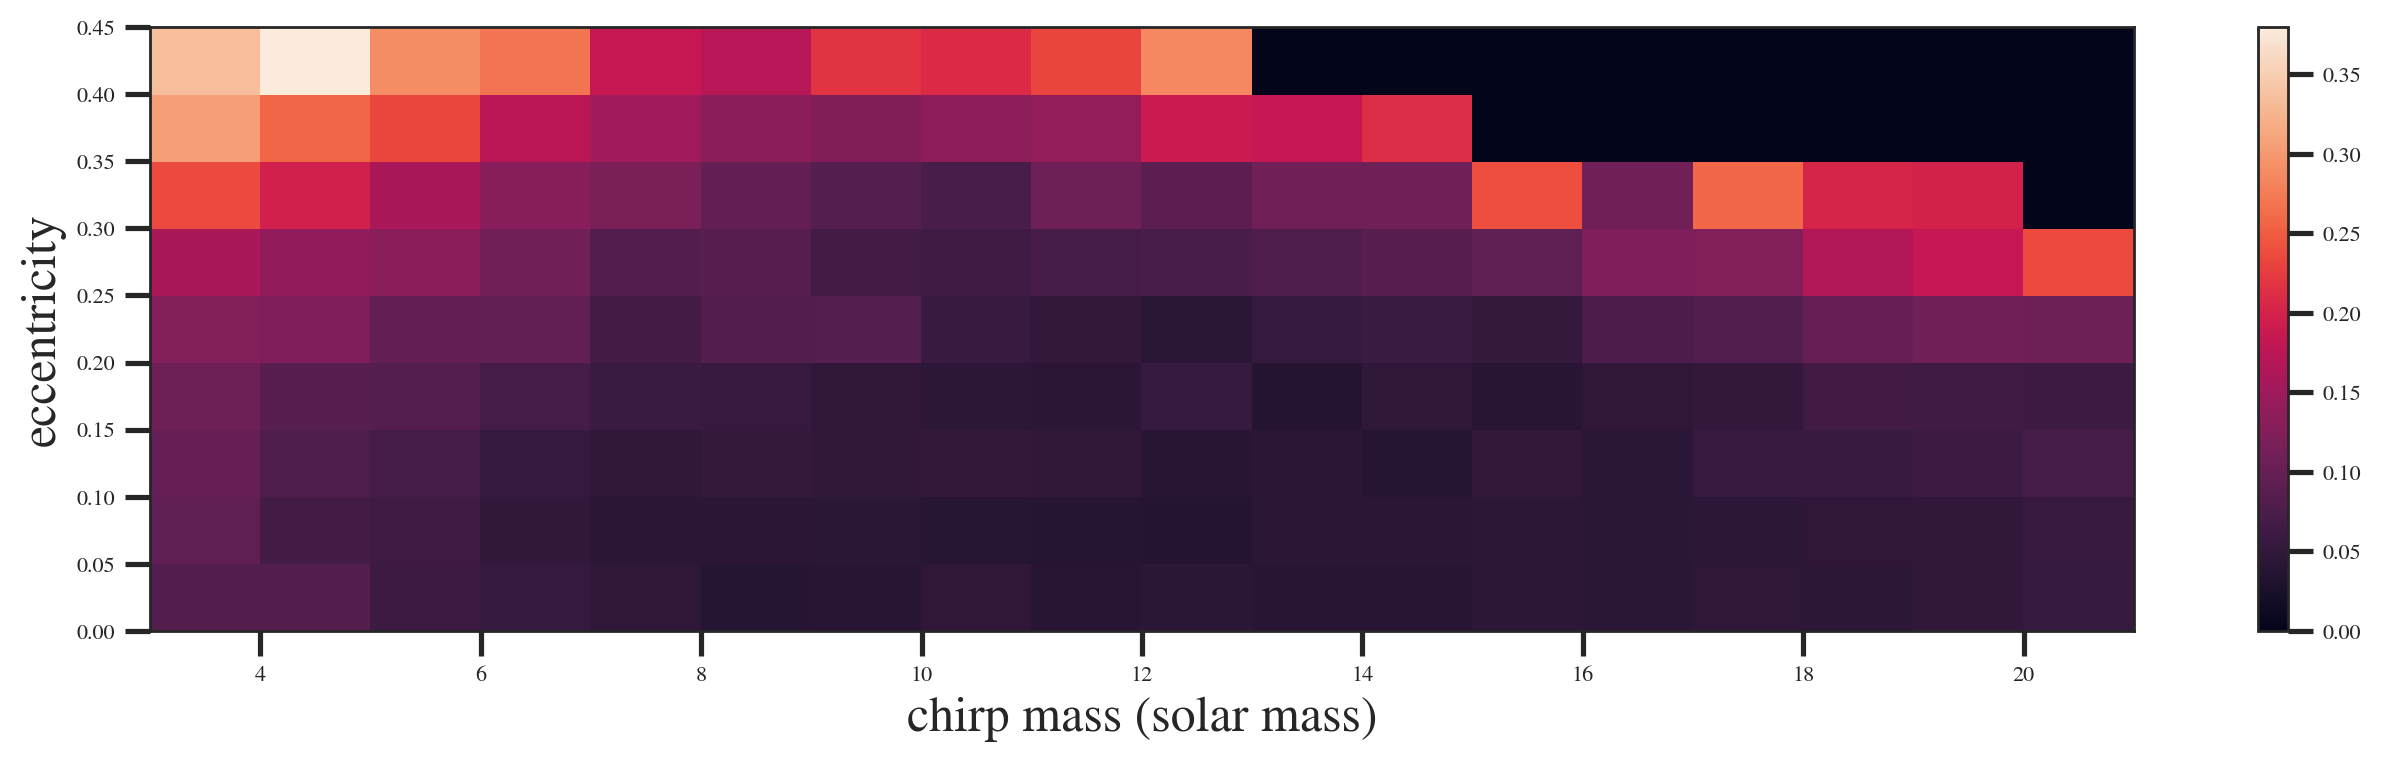

In [ ]:
pylab.figure(figsize=(16,4))
pylab.grid(zorder=1)
pylab.pcolormesh(ms, es, std_mine2.T)
print(np.max(std_mine2))
# pylab.ylim(10, 512)
# pylab.xlim(10, 760/m)
pylab.xlabel('chirp mass (solar mass)')
pylab.ylabel('eccentricity')
# pylab.yscale('log')
pylab.colorbar()
pylab.show()

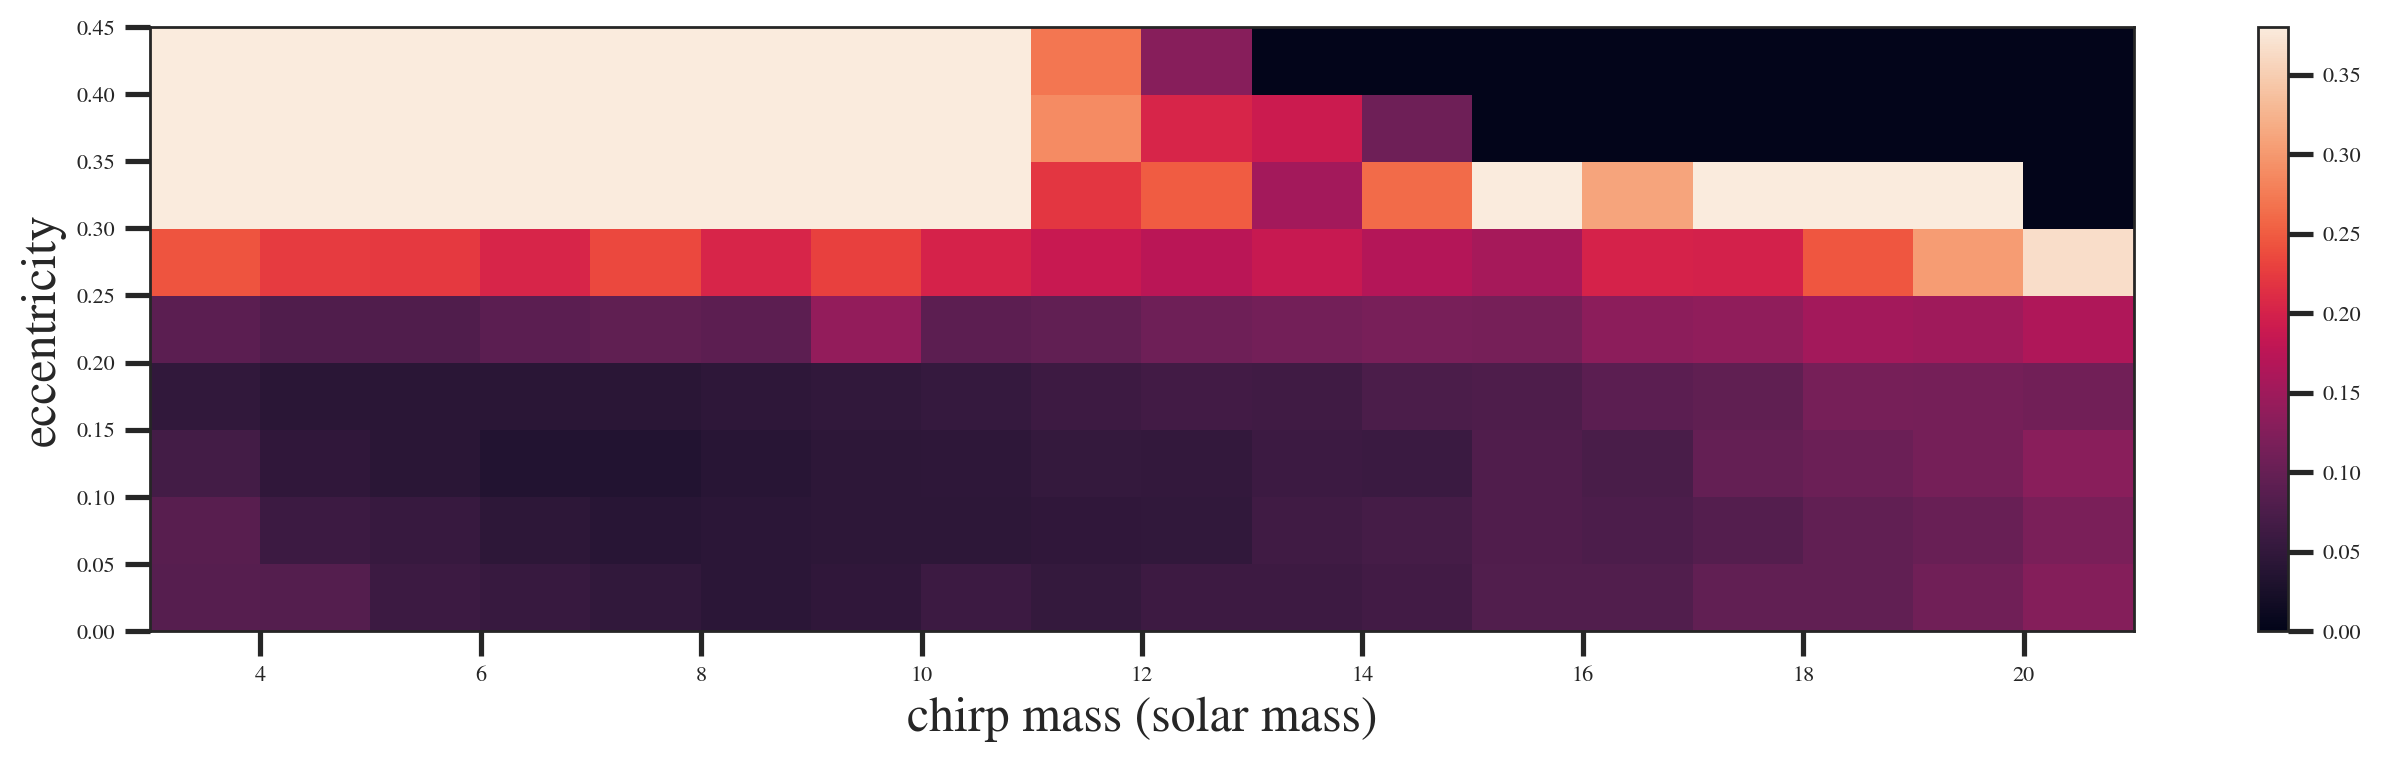

In [ ]:
pylab.figure(figsize=(16,4))
pylab.grid()
pylab.pcolormesh(ms, es, std_nirban2.T, vmax = 0.38)
# pylab.ylim(10, 512)
# pylab.xlim(10, 760/m)
pylab.xlabel('chirp mass (solar mass)')
pylab.ylabel('eccentricity')
# pylab.yscale('log')
pylab.colorbar()
pylab.show()

In [ ]:
std_subtract = np.subtract(std_nirban2, std_mine2)
print(std_subtract)

[[ 1.80262667e-03 -6.80839794e-03 -3.24300993e-02 -5.66220969e-02
  -3.72517827e-02  8.54985675e-02  4.10695957e-01  1.25370103e+00
   3.02981771e+00]
 [ 1.03500478e-03 -7.78921684e-03 -3.04025465e-02 -4.58817406e-02
  -4.31598910e-02  8.49531853e-02  3.99975993e-01  1.11440609e+00
   2.25739661e+00]
 [ 1.21739438e-03 -7.37684292e-03 -2.72528025e-02 -4.07652794e-02
  -1.87417693e-02  9.20034516e-02  4.25631975e-01  9.58041817e-01
   1.91346257e+00]
 [ 1.80597784e-03 -4.96842634e-03 -1.98747269e-02 -2.60380336e-02
  -6.54057845e-03  9.43924108e-02  4.28310942e-01  9.88321214e-01
   1.67571624e+00]
 [ 3.29654759e-03 -2.31495311e-03 -1.22613309e-02 -1.61506895e-02
   2.64038935e-02  1.52566237e-01  3.72908232e-01  7.09588152e-01
   1.02535758e+00]
 [ 4.60966732e-03  5.49561253e-04 -1.13871186e-02 -8.84070360e-03
   9.04457828e-03  1.16004564e-01  3.71452766e-01  6.00661274e-01
   8.48795607e-01]
 [ 7.66690173e-03  2.55322640e-03 -3.89126530e-03  3.41057350e-04
   5.62154681e-02  1.6226979

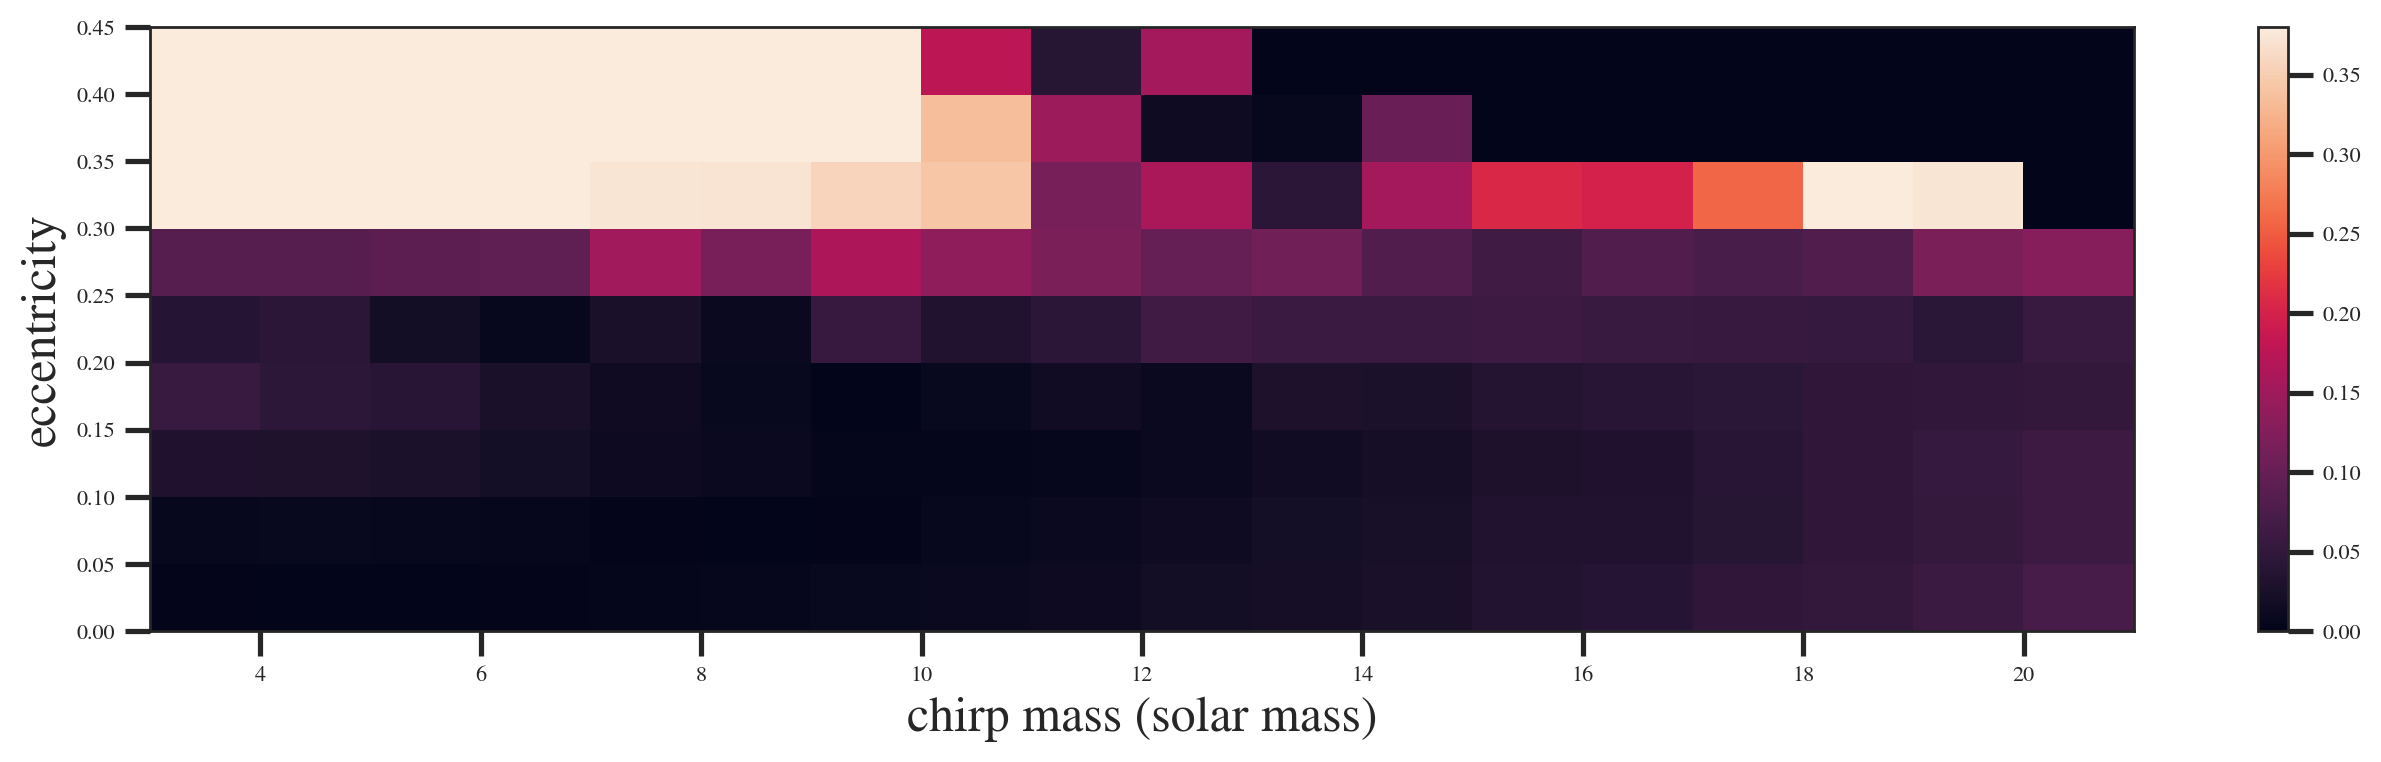

In [ ]:
pylab.figure(figsize=(16,4))
pylab.grid()
pylab.pcolormesh(ms, es, np.abs(std_subtract.T), vmax = 0.38)
# pylab.ylim(10, 512)
# pylab.xlim(10, 760/m)
pylab.xlabel('chirp mass (solar mass)')
pylab.ylabel('eccentricity')
# pylab.yscale('log')
pylab.colorbar()
pylab.show()

In [ ]:
std_mine_1 = np.loadtxt('std_mine (1).txt')
# print(std_mine_1)
std_mine_1[10][7] = 1.7576247425933682
std_mine_11 = std_mine_1**0.5
print(std_mine_11)
print(0.1*(np.max(std_mine_11)-np.min(std_mine_11)))

[[0.55231206 0.6073036  0.43447672 0.50356905 0.7064142  0.73298332
  0.86473784 1.03925617 1.1071682 ]
 [0.40998066 0.42714381 0.4666511  0.52105005 0.61143687 0.7339045
  0.78881846 0.95367373 1.27558635]
 [0.39745255 0.44607991 0.43294358 0.6972101  0.79858887 0.8740289
  0.7608023  0.92052565 1.0428626 ]
 [0.38690945 0.40975081 0.46764721 0.52447128 0.59393603 0.64981327
  0.91682275 0.86101902 1.27933148]
 [0.42968912 0.4588113  0.4807146  0.49013128 0.5732867  0.65442735
  0.88558188 1.64203558 1.22020272]
 [0.44254489 0.43212281 0.48027639 0.4981328  0.89320816 0.69077576
  1.31267256 1.29277491 2.00571285]
 [0.41829757 0.44720159 0.51992983 0.57986087 0.55351979 1.10563446
  0.87226976 2.26585167 1.49900465]
 [0.42995089 0.45477078 0.52904376 0.52299402 0.93946039 1.64087935
  2.23393274 2.01774396 2.32956725]
 [0.46956828 0.46672483 0.52925908 0.71629192 1.1137256  1.55972346
  1.49435725 3.34826033 2.21912688]
 [0.45147401 0.5434636  0.51872785 0.56472702 0.70361354 1.8224641

In [ ]:
std_nirban_1 = np.loadtxt('std_nirban (1).txt')
print(std_nirban_1.shape)
std_nirban_1[10][7] = 1.4631391358465775
std_nirban_11 = std_nirban_1**0.5
print(std_nirban_1)

(18, 9)
[[ 0.30741701  0.34725415  0.10991333  0.08964659  0.20485597  0.28759365
   0.68565947  1.90038923  3.03552468]
 [ 0.1721008   0.16372883  0.14246595  0.11023091  0.14474572  0.26753602
   0.67141106  1.37714462  2.7109886 ]
 [ 0.16507321  0.18548108  0.12391182  0.32353384  0.39196458  0.50143075
   0.62927435  1.14003059  2.26724444]
 [ 0.16061732  0.16202686  0.16318377  0.15423604  0.18298154  0.31529116
   0.92011474  1.24504663  1.80098357]
 [ 0.20465304  0.21262423  0.18721781  0.1539915   0.18844985  0.31029702
   0.68589873  1.56916557  1.38447681]
 [ 0.22417644  0.19856061  0.19662253  0.16778031  0.6198609   0.33043147
   1.07861678  0.92893621  1.77520328]
 [ 0.2085992   0.21867963  0.24718438  0.24541171  0.22162668  0.90871942
   0.46177182  2.29620221  0.71897716]
 [ 0.22841214  0.23782473  0.26842662  0.22246779  0.72249924  1.94942332
   3.10564383  2.02506395  1.23865675]
 [ 0.28324805  0.25860531  0.2911619   0.43979733  1.01256267  1.77571762
   1.2542645  

In [ ]:
ms1 = np.linspace(3,20,18)
es1 = np.linspace(0,0.4,9)

In [ ]:
# levels = MaxNLocator(nbins=10).tick_values(std_mine_1.min(), std_mine_1.max())
# cmap = plt.get_cmap()
# norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
# plt.figure(figsize = (12, 6))
# plt.subplot(2, 1, 1)
# im = plt.pcolormesh(ms, es, std_mine_11.T, cmap=cmap, norm=norm)
# plt.colorbar()
# # set the limits of the plot to the limits of the data
# plt.axis([ms.min(), ms.max(), es.min(), es.max()])
# # plt.title('pcolormesh with levels')

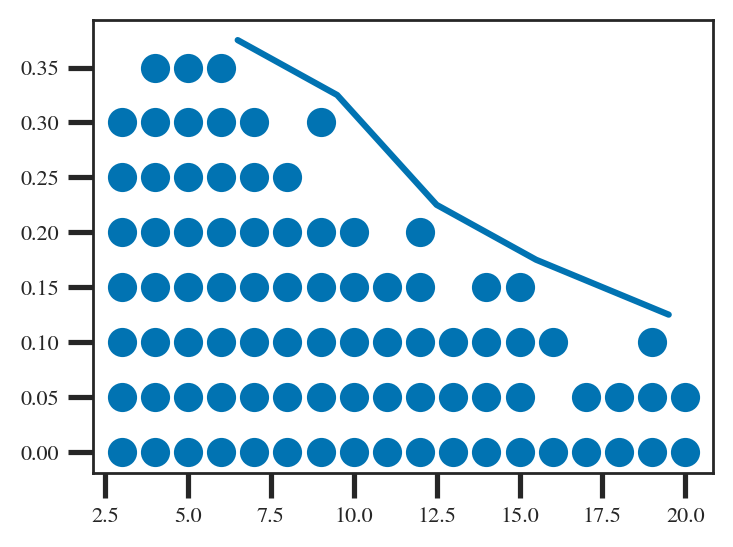

In [ ]:
# curve_mine_x = np.array([7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5])
# curve_mine_y = np.array([0.425, 0.375, 0.325, 0.275, 0.25, 0.225, 0.2, 0.175, 0.15, 0.125, 0.125, 0.125, 0.125, 0.125])
# model=make_interp_spline(curve_mine_x, curve_mine_y)
# xs=np.linspace(7.5,20.5,500)
# ys=model(xs)
# X_Y_Spline = make_interp_spline(curve_mine_x, curve_mine_y)
# X_ = np.linspace(curve_mine_x.min(), curve_mine_x.max(), 500)
# Y_ = X_Y_Spline(X_)
curve_x = []
curve_y = []
for i in range(18):
  for j in range(9):
    if std_mine_11[i][j] <= 1:
      curve_x.append(ms[i])
      curve_y.append(es[j])
plt.scatter(curve_x, curve_y)
curve_mine_x = np.array([6.5, 9.5, 12.5, 15.5, 19.5])
curve_mine_y = np.array([0.375, 0.325, 0.225, 0.175, 0.125])
plt.plot(curve_mine_x, curve_mine_y)

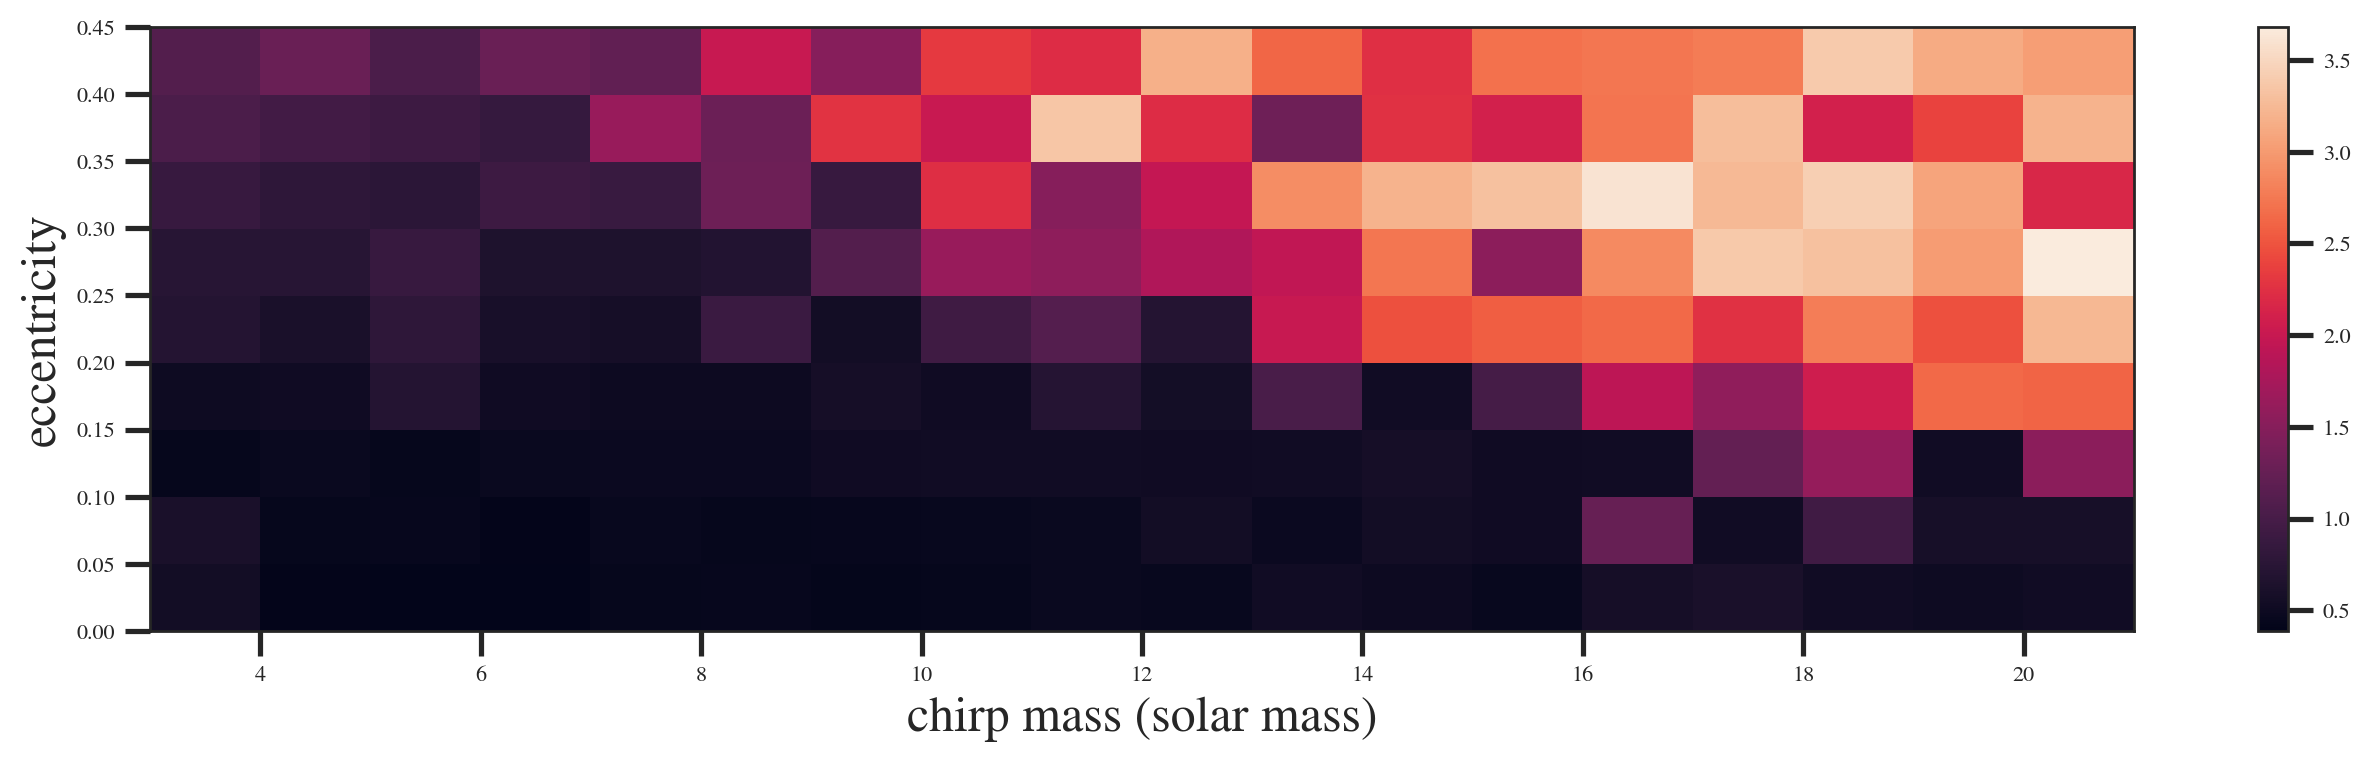

In [ ]:
pylab.figure(figsize=(16,4))
pylab.grid(zorder=1)
pylab.pcolormesh(ms, es, std_mine_11.T)
# pylab.plot(xs, ys)
# pylab.plot(curve_mine_x, curve_mine_y)
# cont = plt.contour(ms1 ,es1 ,std_mine_1.T)
# print(np.max(std_mine_1))
# pylab.ylim(0, 0.45)
# pylab.xlim(10, 760/m)
pylab.xlabel('chirp mass (solar mass)')
pylab.ylabel('eccentricity')
# pylab.yscale('log')
pylab.colorbar()
pylab.show()

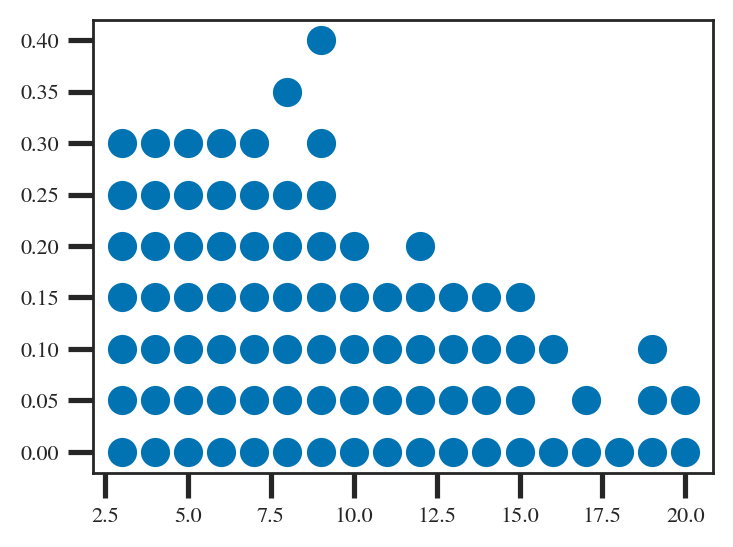

In [ ]:
curve_x = []
curve_y = []
for i in range(18):
  for j in range(9):
    if std_nirban_11[i][j] <= 1:
      curve_x.append(ms[i])
      curve_y.append(es[j])
plt.scatter(curve_x, curve_y)

In [ ]:
curve_nirban_x = np.array([7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5])
curve_nirban_y = np.array([0.425, 0.375, 0.325, 0.275, 0.25, 0.225, 0.2, 0.175, 0.15, 0.125, 0.125, 0.125, 0.125, 0.125])
model=make_interp_spline(curve_mine_x, curve_mine_y)
xs=np.linspace(7.5,20.5,500)
ys=model(xs)

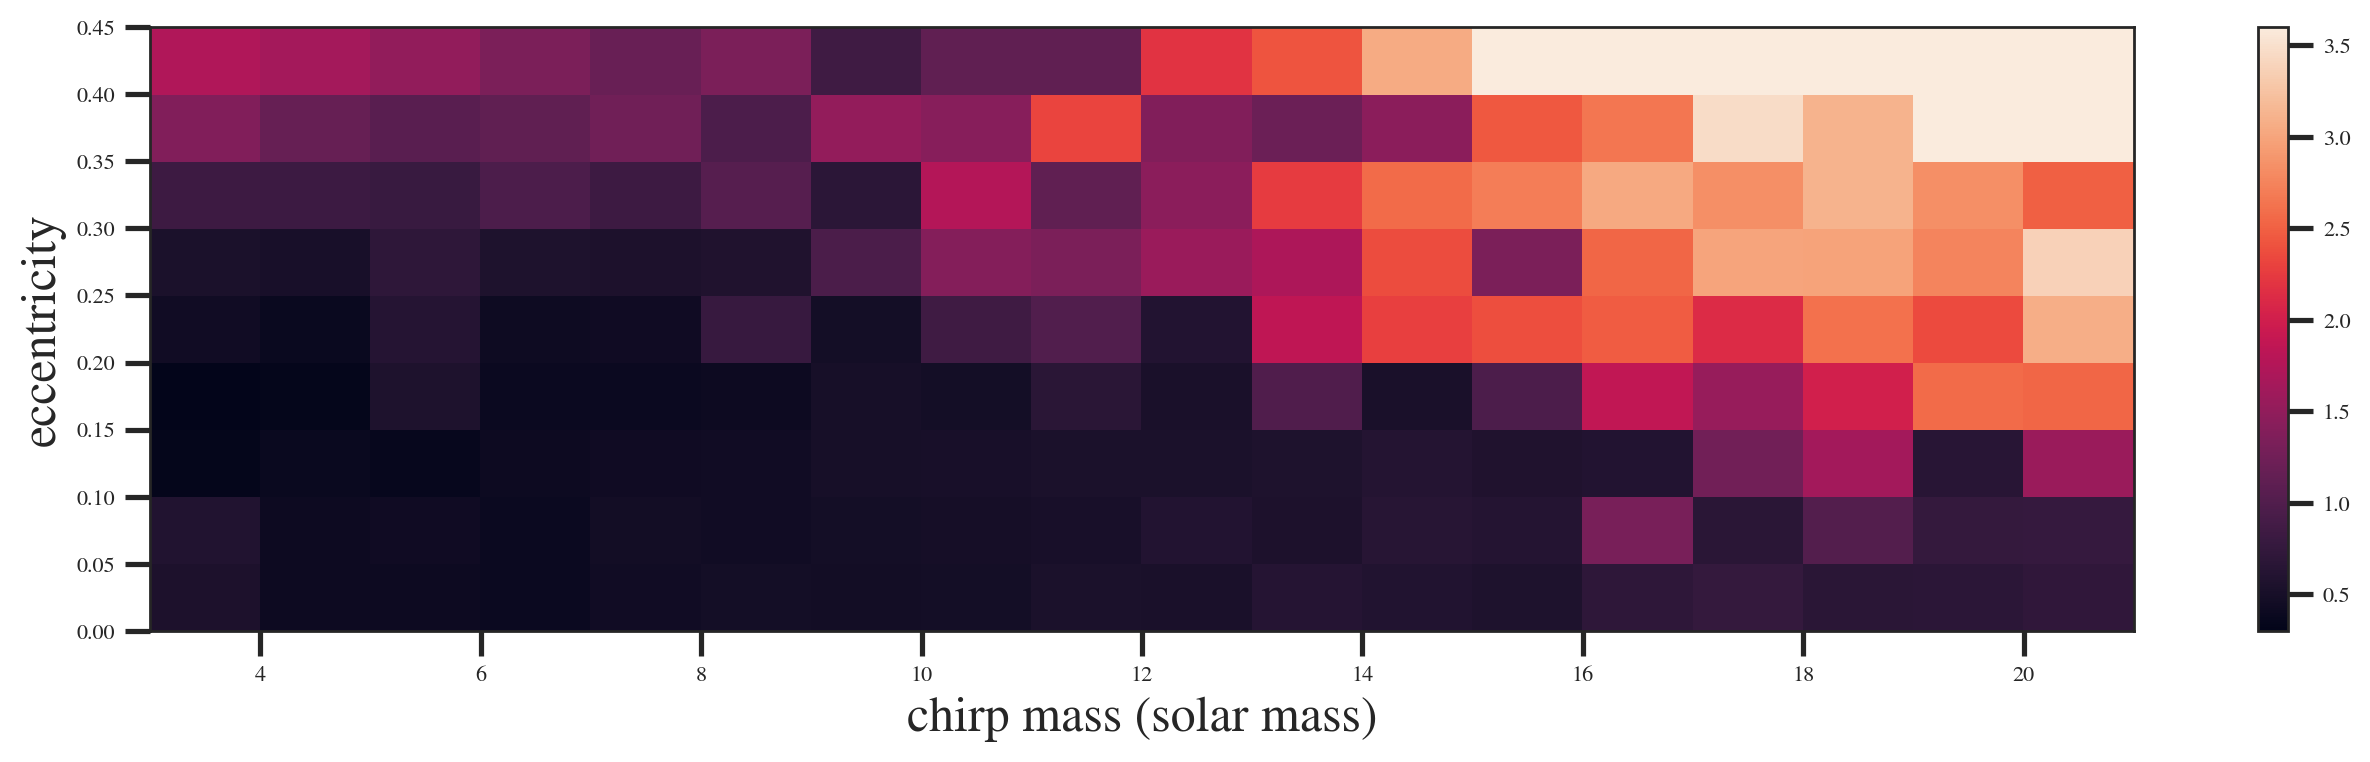

In [ ]:
pylab.figure(figsize=(16,4))
pylab.grid(zorder=1)
pylab.pcolormesh(ms, es, std_nirban_11.T, vmax = 3.6)
# print(np.max(std_mine_1))
# pylab.ylim(10, 512)
# pylab.xlim(10, 760/m)
pylab.xlabel('chirp mass (solar mass)')
pylab.ylabel('eccentricity')
# pylab.yscale('log')
pylab.colorbar()
pylab.show()

In [ ]:
std_mine_2 = [[1.069598928492333234e-01, 1.038444239186055579e-01, 1.068209053673396108e-01, 1.438920196871677493e-01, 1.329867721206604014e-01, 1.609113661746357504e-01, 2.115228722478549872e-01, 2.879528380173363433e-01, 3.609966940612148179e-01],
[7.794787715024484309e-02, 7.950070443345813587e-02, 7.650542039852917253e-02, 9.977150717725546958e-02, 1.193583762800183717e-01, 1.445729843357719813e-01, 1.970819345198245309e-01, 2.640949093602028563e-01, 3.230703528158530013e-01],
[6.577333898360153419e-02, 6.781628200649773841e-02, 8.496128772917833916e-02, 8.161582494907750063e-02, 9.985181952201557798e-02, 1.386142407421406819e-01, 1.820487234866710879e-01, 2.259090221112447228e-01, 2.730296281655981150e-01],
[5.811618269813341453e-02, 5.803404663153505227e-02, 6.333142468050981244e-02, 6.526596573879450691e-02, 9.531752735617665673e-02, 1.112347381331811047e-01, 1.304619955822834410e-01, 1.733757530475379116e-01, 2.188708370809497317e-01],
[7.185983769938000809e-02, 4.822921275031633037e-02, 8.729620042883801112e-02, 6.012698182035104005e-02, 8.791100813846894346e-02, 9.423763124914676104e-02, 1.320862590484049026e-01, 1.528123429451543891e-01, 1.739071048662158558e-01],
[6.071154624613730316e-02, 4.821351117764571120e-02, 6.344810548146805063e-02, 5.420236238387071692e-02, 6.198499325102740931e-02, 7.169804634387762221e-02, 8.569774596284339407e-02, 1.407249211636403541e-01, 1.619793636454177066e-01],
[5.547274360977800384e-02, 4.021718889365262506e-02, 8.161301700651203694e-02, 4.593280961381394911e-02, 5.420040155134050325e-02, 1.249325386599107329e-01, 1.200300431848397853e-01, 1.243965001053980446e-01, 1.399115186170274694e-01],
[4.120872996081900719e-02, 4.357173332123530363e-02, 6.355630479532083099e-02, 5.855746346286139908e-02, 5.205707450170680289e-02, 7.634177314906112621e-02, 7.064904120361875650e-02, 1.321691937704026210e-01, 1.985816862120842463e-01],
[3.902083049525965908e-02, 3.675569496462358088e-02, 7.664392131035055455e-02, 3.942848565604357286e-02, 4.609039689480409763e-02, 1.009368835077989052e-01, 6.705540207717440582e-02, 1.687408444571335264e-01, 2.121841339348532751e-01],
[4.953672661625049128e-02, 3.907441542283632274e-02, 4.913779842524919339e-02, 5.187906341618990502e-02, 5.046527566855318891e-02, 8.182453040896946195e-02, 1.175484380536036683e-01, 1.559679163719976391e-01, 3.814614134883821950e-01],
[3.601639609642019735e-02, 3.511088944263886236e-02, 7.388743160065887328e-02, 4.401646954652598670e-02, 6.063920963200313680e-02, 1.537998621261877641e-01, 1.362797909921904249e-01, 1.833378256561596364e-01, 1.404470037465604948e-01],
[4.031060829250898703e-02, 3.537185716008788700e-02, 4.289560070930979740e-02, 5.243601440851738266e-02, 5.267495269488041421e-02, 7.929580895049036238e-02, 1.578774778616191532e-01, 2.959267664457360114e-01, 4.305233543799205642e-01],
[3.634654813631892079e-02, 4.647914054237928250e-02, 5.620562150067770490e-02, 5.250653619326754729e-02, 6.725875668280764663e-02, 8.591646312456638346e-02, 1.549087076373658611e-01, 3.000421275767242713e-01, 1.909912665549852728e-01],
[4.297532040362202210e-02, 4.073859310636399056e-02, 4.525101250977840717e-02, 7.320121415805769249e-02, 9.853341529228154538e-02, 1.015714405474797827e-01, 1.456627882194626578e-01, 2.970690660394494920e-01, 2.111508594811294381e-01],
[4.325263205962032176e-02, 3.983134853916250190e-02, 4.900686619744871325e-02, 5.587197172352598856e-02, 4.812614327996447144e-02, 1.826524482918510384e-01, 1.956505440566584098e-01, 4.931870466704465494e-01, 2.371735293016904444e-01],
[4.945274038150336560e-02, 3.891570620107028672e-02, 5.800245140290147955e-02, 9.080293930683402959e-02, 8.680996597662189729e-02, 1.654685848799604120e-01, 2.565222164840931240e-01, 3.388425725821508361e-01, 1.478821256859982058e-01],
[4.694105311436802541e-02, 4.956783467378862718e-02, 6.026903188389325094e-02, 7.505179287520349907e-02, 1.094642613500658723e-01, 1.689794543969262985e-01, 2.808289272277962878e-01, 2.561647317047636707e-01, 1.078657185891353648e-01],
[4.609765346255202678e-02, 5.055697980945102199e-02, 5.529345290053843537e-02, 1.126473606195199234e-01, 1.612067154230374944e-01, 2.049993275204143039e-01, 3.760775535003250125e-01, 2.591399839692552498e-01, 1.716496210655477916e-01]]

std_mine2 = np.array(std_mine_2)
print(std_mine2.shape)

(18, 9)


In [ ]:
std_nirban_2 = np.loadtxt('std_nirban (2).txt')
print(std_nirban_2.shape)

(18, 9)


0.49318704667044655


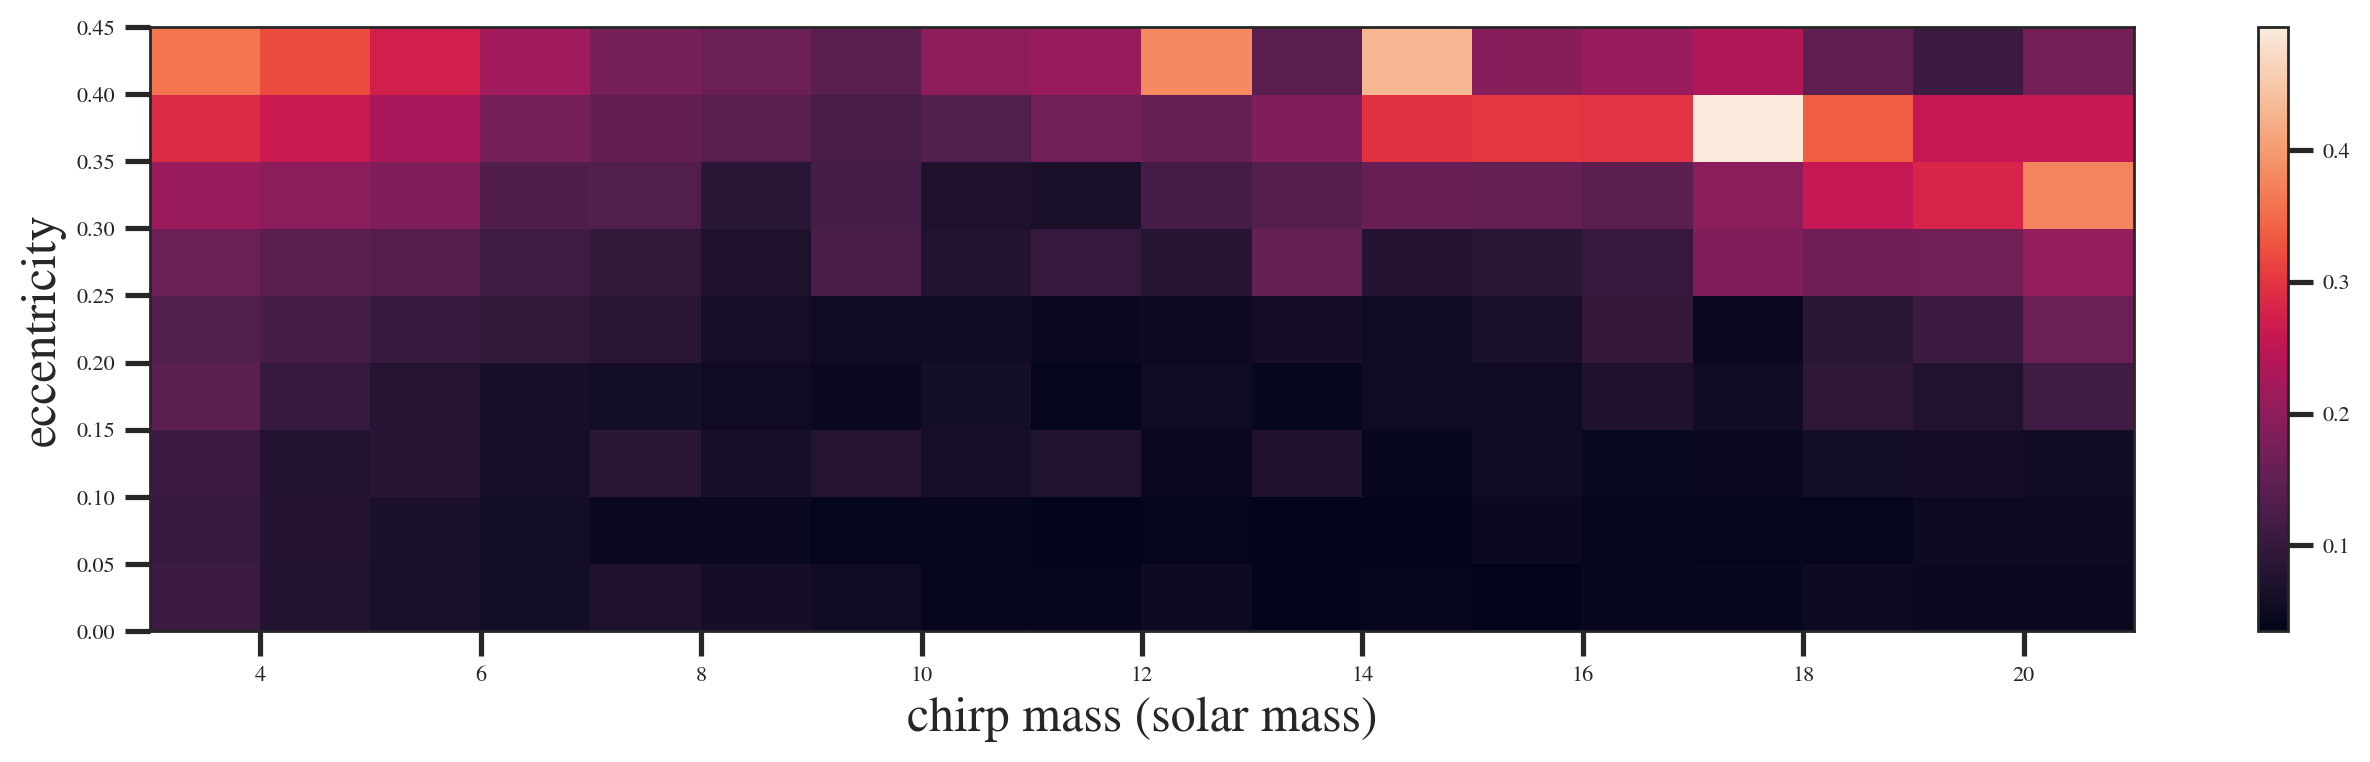

In [ ]:
pylab.figure(figsize=(16,4))
pylab.grid(zorder=1)
pylab.pcolormesh(ms, es, std_mine2.T)
print(np.max(std_mine2))
# pylab.ylim(10, 512)
# pylab.xlim(10, 760/m)
pylab.xlabel('chirp mass (solar mass)')
pylab.ylabel('eccentricity')
# pylab.yscale('log')
pylab.colorbar()
pylab.show()

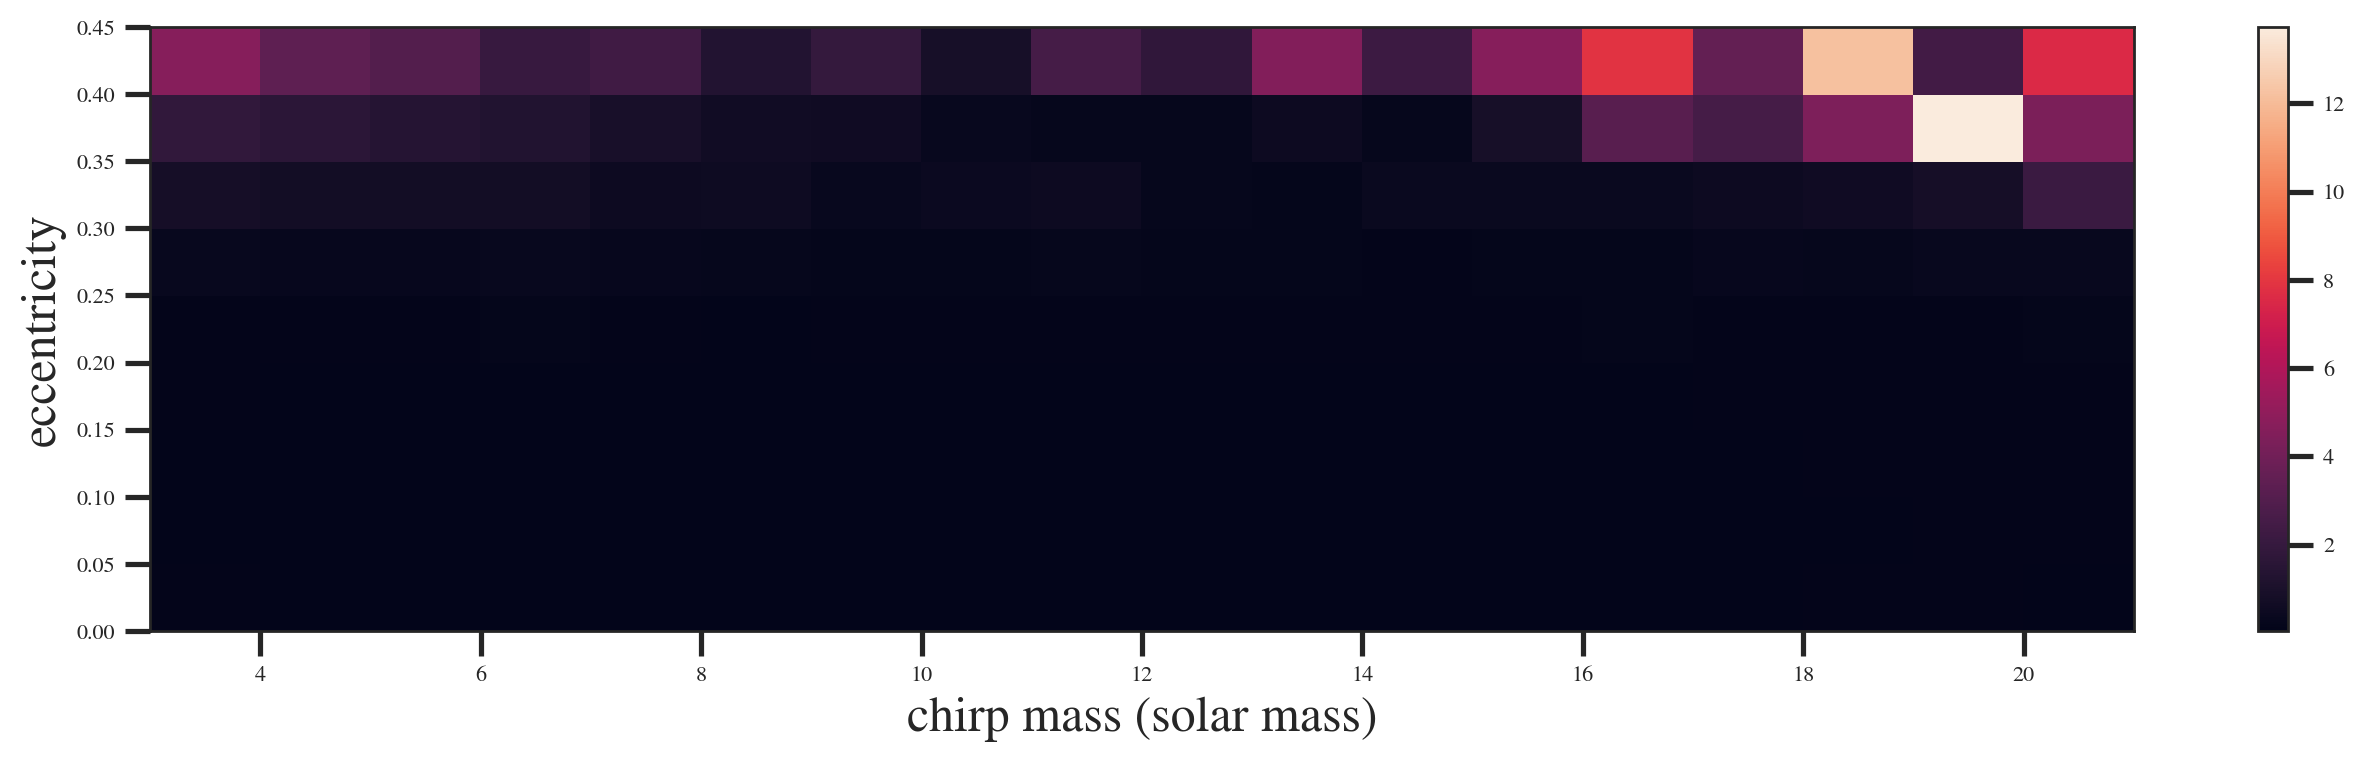

In [ ]:
pylab.figure(figsize=(16,4))
pylab.grid(zorder=1)
pylab.pcolormesh(ms, es, std_nirban_2.T)
# print(np.max(std_mine2))
# pylab.ylim(10, 512)
# pylab.xlim(10, 760/m)
pylab.xlabel('chirp mass (solar mass)')
pylab.ylabel('eccentricity')
# pylab.yscale('log')
pylab.colorbar()
pylab.show()